# Laboratorio 7: Selección de Atributos

Integrantes: Adolfo Ignacio Rojas Valenzuela (sección 2), Emilia Chávez Salamanca (sección 1)

# Datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

from sklearn.datasets import load_digits

X, y = load_digits(return_X_y=True)
sns.set_theme()

In [2]:
X.shape
# Visualizar cada imagen
# for digito in range(10):
#     plt.imshow(X[digito].reshape(8, 8), cmap='gray')
#     plt.title(f"Dígito: {y[digito]}")
#     plt.show()

(1797, 64)

In [3]:
digitos, frecuencias = np.unique(y, return_counts=True)
print(
    pd.DataFrame({
        "dígito/clase": digitos, 
        "frecuencia": frecuencias
    }).reset_index(drop=True).to_string(index=False)
)

 dígito/clase  frecuencia
            0         178
            1         182
            2         177
            3         183
            4         181
            5         182
            6         181
            7         179
            8         174
            9         180


# Análisis Exploratorio

**P0** - Para cada parte de esta sección, responda adicionalmente las siguientes preguntas:
1. ¿Qué puede decir de los datos a partir de estos resultados?
2. ¿Considera que hay que remover alguna columna?

Si la respuesta de la segunda pregunta es afirmativa, elimine esas columnas. Guarde cada modificación que haga sobre los datos en una nueva variable `X2` y mantenga `X` sin modificar.

**P1** - Determine la proporción de los datos que es igual a $0$ y si existen columnas que sólo contienen este valor.

In [4]:
dimensiones = X.size
nulos = np.sum(X == 0)
zero_cols = np.where(np.all(X == 0, axis=0))[0].tolist()

display(Markdown(f"Cantidad de negros/ceros: {nulos}"))
display(Markdown(f"Proporción de negros/ceros: {(nulos/dimensiones*100).round(2)}%"))
display(Markdown(f"Índice de pixeles siempre inactivos: {zero_cols}"))

Cantidad de negros/ceros: 56272

Proporción de negros/ceros: 48.93%

Índice de pixeles siempre inactivos: [0, 32, 39]

**Respuesta:**
De esto podemos ver que ~50% de los pixeles son de color negro (a nivel dataset, no por cada imagen) y que hay pixeles que nunca se activan (no cambian del negro/color por defecto) los cuales al ser tan pocos (3 de 64 pixeles) no afectará el entrenamiento de un modelo el hecho de eliminarlas o no

In [5]:
X2 = np.delete(X, zero_cols, axis=1)

**P2** - Visualize la matriz de correlación para `X2`. Dada la cantidad de columnas, puede ser útil visualizar también la matriz son subconjuntos más pequeños para un análisis más preciso.

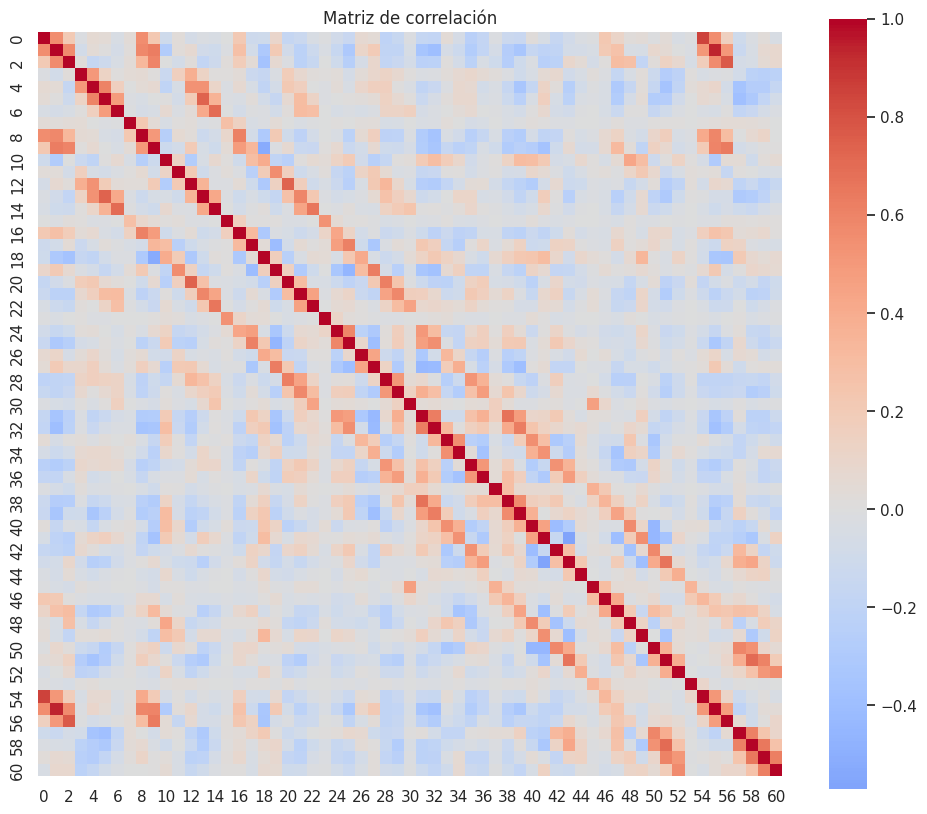

In [6]:
df = pd.DataFrame(X2)
corr_matrix = df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, square=True)
plt.title("Matriz de correlación")
plt.show()

# for i in range(0, df.shape[1], 10):
#     sns.heatmap(df.iloc[:, i:i+10].corr(), cmap='coolwarm', center=0)
#     plt.title(f"Correlación de columnas {i} a {min(i+9, df.shape[1]-1)}")
#     plt.show()

**Respuesta:** Recordando que cada imagen de 8x8 es descrita por un flatten array podemos ver que los pixeles contiguos (o muy cercanos al pixel central) tienen alta correlación (tienen un tono muy similar), luego a medida que se aumenta la ventana se da más comunmente la correlación negativa (se detecta un borde/el pixel tiene un tono que contrasta más con respecto al pixel central). Respecto a remover columnas dada la alta correlación podríamos hacer feature reduction para concentrar la información relevante

In [7]:
from sklearn.decomposition import PCA

# Nos "deshacemos" de la mitad de diagonales de la matriz de correlación
pca = PCA(n_components=64//2)
X2 = pca.fit_transform(X2)

**P3** - Calcule la varianza de los datos.

In [8]:
arreglos = {
    "original": X,
    "modificado": X2,
}

for nombre, arr in arreglos.items():
    varianza = np.var(arr, axis=0).sum()
    display(Markdown(f"Varianza del arreglo {nombre}: {varianza:.2f}"))

Varianza del arreglo original: 1201.48

Varianza del arreglo modificado: 1161.05

**Respuesta:** Al haber aplicado PCA, ya transformamos los datos en un nuevo espacio de componentes ordenadas según su varianza, conservando aquellas con mayor información (varianza). Por lo tanto, aplicar VarianceThreshold después de PCA es innecesario, ya que las componentes de menor varianza ya fueron descartadas.
Solo tendría sentido aplicar VarianceThreshold con un umbral muy restrictivo, lo que eliminaría parte de nuestras n_components, lo que iría en contra de conservar la mayor cantidad de información posible

# Selección de Atributos

In [9]:
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif, chi2 
from sklearn.model_selection import train_test_split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

**P4** - Selecciones las 30 mejores columnas según el criterio de información mutua.

In [11]:
# SelectKBest(score_func, *, k)
fns = [mutual_info_classif]

for score_func in fns:
    selector = SelectKBest(score_func, k=30)
    selector.fit(X_train, y_train)
    
    X3_train = selector.transform(X_train)
    X3_test = selector.transform(X_test)
    
    # Comparar para otras score_func
    # pixeles = selector.get_support(indices=True)
    # scores = selector.scores_[pixeles]
    # df_scores = pd.DataFrame({
    #     "pixel": pixeles,
    #     "score": scores
    # })
    
    # display(df_scores)

**P5** - Seleccione las columnas más útiles según los resultados de un árbol de clasificación. Seleccione un máximo de 30.

In [12]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(random_state=0)
dtc.fit(X_train, y_train)

selector = SelectFromModel(dtc, max_features=30, prefit=True)

X4_train = selector.transform(X_train)
X4_test = selector.transform(X_test)

# pixeles = selector.get_support(indices=True)
# scores = dtc.feature_importances_
# scores = scores[pixeles]
# df_scores = pd.DataFrame({
#     "pixel": pixeles,
#     "score": scores
# })

# display(df_scores)

# Clasificación

**P6** - Entrene y evalue un clasificador SVC para el dataset sin reducir y cada una de las reducciones hechas en las preguntas anteriores. Para cada caso mida el tiempo de entrenamiento y grafique la matriz de confusión, luego compare y comente los resultados.

In [15]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import time

X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size=0.3, stratify=y, random_state=0)

def plot_confusion_matrix(true_label, pred_label):
    mat = confusion_matrix(true_label, pred_label)

    fig, ax = plt.subplots()

    ax = sns.heatmap(mat, annot=True, cmap='Reds')
    ax.set_ylabel("True Label")
    ax.set_xlabel("Predicted Label")

    plt.show()

Métricas de performance para baseline:

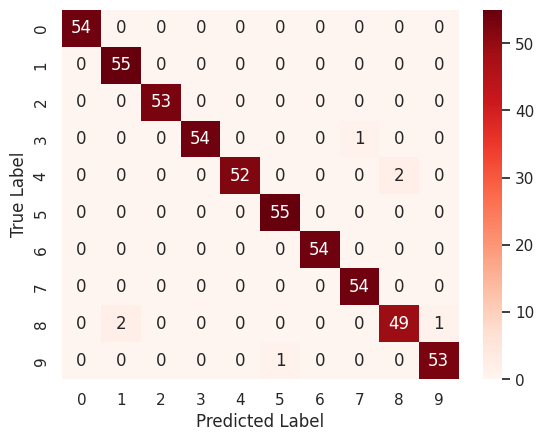

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        54
           1     0.9649    1.0000    0.9821        55
           2     1.0000    1.0000    1.0000        53
           3     1.0000    0.9818    0.9908        55
           4     1.0000    0.9630    0.9811        54
           5     0.9821    1.0000    0.9910        55
           6     1.0000    1.0000    1.0000        54
           7     0.9818    1.0000    0.9908        54
           8     0.9608    0.9423    0.9515        52
           9     0.9815    0.9815    0.9815        54

    accuracy                         0.9870       540
   macro avg     0.9871    0.9869    0.9869       540
weighted avg     0.9872    0.9870    0.9870       540



Tiempo de entrenamiento: 0.0375s

----

Métricas de performance para PCA:

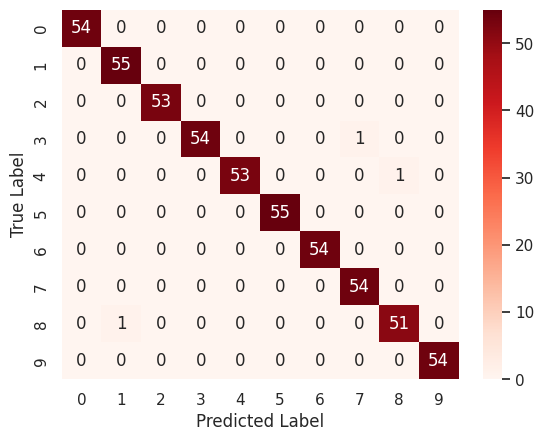

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        54
           1     0.9821    1.0000    0.9910        55
           2     1.0000    1.0000    1.0000        53
           3     1.0000    0.9818    0.9908        55
           4     1.0000    0.9815    0.9907        54
           5     1.0000    1.0000    1.0000        55
           6     1.0000    1.0000    1.0000        54
           7     0.9818    1.0000    0.9908        54
           8     0.9808    0.9808    0.9808        52
           9     1.0000    1.0000    1.0000        54

    accuracy                         0.9944       540
   macro avg     0.9945    0.9944    0.9944       540
weighted avg     0.9945    0.9944    0.9944       540



Tiempo de entrenamiento: 0.0412s

----

Métricas de performance para Mutual info:

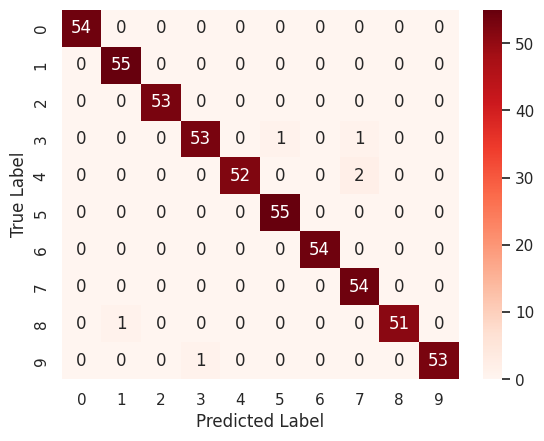

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        54
           1     0.9821    1.0000    0.9910        55
           2     1.0000    1.0000    1.0000        53
           3     0.9815    0.9636    0.9725        55
           4     1.0000    0.9630    0.9811        54
           5     0.9821    1.0000    0.9910        55
           6     1.0000    1.0000    1.0000        54
           7     0.9474    1.0000    0.9730        54
           8     1.0000    0.9808    0.9903        52
           9     1.0000    0.9815    0.9907        54

    accuracy                         0.9889       540
   macro avg     0.9893    0.9889    0.9890       540
weighted avg     0.9892    0.9889    0.9889       540



Tiempo de entrenamiento: 0.0336s

----

Métricas de performance para DecisionTree:

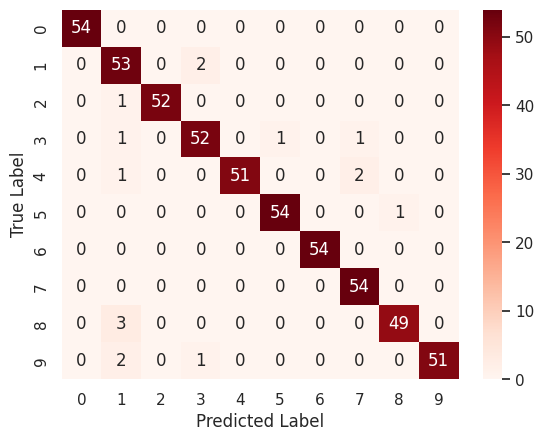

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        54
           1     0.8689    0.9636    0.9138        55
           2     1.0000    0.9811    0.9905        53
           3     0.9455    0.9455    0.9455        55
           4     1.0000    0.9444    0.9714        54
           5     0.9818    0.9818    0.9818        55
           6     1.0000    1.0000    1.0000        54
           7     0.9474    1.0000    0.9730        54
           8     0.9800    0.9423    0.9608        52
           9     1.0000    0.9444    0.9714        54

    accuracy                         0.9704       540
   macro avg     0.9723    0.9703    0.9708       540
weighted avg     0.9720    0.9704    0.9707       540



Tiempo de entrenamiento: 0.0273s

----

In [18]:
datasets = {
    "baseline": (X_train, X_test),
    "PCA": (X2_train, X2_test),
    "Mutual info": (X3_train, X3_test),
    "DecisionTree": (X4_train, X4_test)
}

for nombre, (X_tr, X_te) in datasets.items():
    svc = SVC(random_state=0)

    inicio = time.time()
    svc.fit(X_tr, y_train)
    entrenamiento = time.time() - inicio
    
    y_pred = svc.predict(X_te)

    display(Markdown(f"Métricas de performance para {nombre}:"))
    plot_confusion_matrix(y_test, y_pred)
    print(classification_report(y_test, y_pred, digits=4))
    display(Markdown(f"Tiempo de entrenamiento: {entrenamiento:.4f}s"))
    display(Markdown(f"----"))

**Respuesta:**
El clasificador logra su mejor desempeño haciendo feature selection y reduction con PCA en el dataset de entrenamiento, luego le precede el de selección basado en información mutua que tiene una accuracy un poco mejor que el baseline al usar solo las 30 columnas que más información aportan, a este le sigue el baseline que sin feature engineering sigue siendo bastante bueno, finalmente, la selección basada en un decision tree es la que se ve más afectada con peor rendimiento que con el dataset original (posiblemente por eliminar columnas extras e incompatibilidad con este algoritmo)